In [55]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback

torch.cuda.set_device(1) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df

In [56]:
df = pd.read_csv("data/WFDB_CPSC2018.csv")
codes =  pd.read_csv("data/codes.csv",sep=";")
# df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
np.sum(codes["SNOMED CT Code"] == int(df.columns[0]))

1

In [57]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
y

array([ True, False, False, ..., False, False, False])

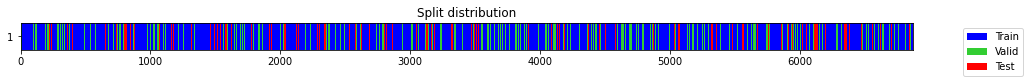

((#4815) [2849,6802,4096,496,2012,173,1178,5343,505,5739...],
 (#1375) [4964,5847,413,6628,1735,5258,6065,3308,3619,3857...],
 (#687) [2626,5678,5053,2717,3363,963,5856,5471,1253,148...])

In [58]:
splits = get_splits(y, valid_size=.2,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [60]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [68]:
MiniRocketPlus?

Init signature:
MiniRocketPlus(
    c_in,
    c_out,
    seq_len,
    num_features=10000,
    max_dilations_per_kernel=32,
    kernel_size=9,
    max_num_channels=None,
    max_num_kernels=84,
    bn=True,
    fc_dropout=0,
    add_lsaz=False,
)
Docstring:     
A sequential container.
Modules will be added to it in the order they are passed in the
constructor. Alternatively, an ``OrderedDict`` of modules can be
passed in. The ``forward()`` method of ``Sequential`` accepts any
input and forwards it to the first module it contains. It then
"chains" outputs to inputs sequentially for each subsequent module,
finally returning the output of the last module.

The value a ``Sequential`` provides over manually calling a sequence
of modules is that it allows treating the whole container as a
single module, such that performing a transformation on the
``Sequential`` applies to each of the modules it stores (which are
each a registered submodule of the ``Sequential``).

What's the difference betw

In [ ]:


def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    max_length = trial.suggest_categorical('max_length',[25,50,100,250,500,700]) # search through all integer values between 3 and 9 with 3 increment steps
    dropout_t = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    dropout_fc = trial.suggest_float("dropout_rate", 0.0, 0.9, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = MiniRocketPlus(dls.vars, dls.c, dls.len, max_seq_len=max_length, dropout=dropout_t, fc_dropout=dropout_fc)
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(200, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "transformer" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize')

study.optimize(objective, n_trials=100)

In [69]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
# model = TST(dls.vars, dls.c, dls.len,max_seq_len=25,dropout=.2,fc_dropout=0.7)
learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=1e-4)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time


TypeError: no implementation found for 'torch.nn.functional.binary_cross_entropy_with_logits' on types that implement __torch_function__: [<class 'tsai.data.core.TSTensor'>, <class 'fastai.torch_core.TensorMultiCategory'>]